# Predicting House Sale Prices in Ames, Iowa

It's hard to think of something more central to the American Dream than the institution of home ownership. For many, being able to own one's own home is one of the most important aspects of our way of life. Indeed, the majority of Americans choose to spend the greater part of their productive lives paying off huge loans (in the form of mortgages) in order to be able to afford a house of their own; this is true for many of us regardless of our race, gender, or socioeconomic status. 

And yet, how many of us really understands what it is we're paying for? What is it exactly that goes into determining the price of a house on the market? 

In this notebook, I'll be looking at data on the prices of several thousand homes in the Midwestern town of Ames, Iowa, with an eye towards figuring out exactly that. 

![ames](https://www.traveliowa.com/userdocs/cities/814_MainStreetBenches-byFayeGilbert.jpg)

## Import libraries and inspect data
To begin with, let's import the required libraries and set customization options, and take a look at the raw data by reading it into a pandas dataframe. 

In [1]:
%matplotlib inline

In [2]:
import itertools
import matplotlib
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import normalize
from pandas.api.types import is_numeric_dtype, is_string_dtype

# read in raw data, drop unnecessary index
data = pd.read_csv("AmesHousing.tsv", delimiter="\t")
data.drop(columns=["Order"], inplace=True)

# library-specific customizations
matplotlib.style.use("ggplot")
pd.set_option("display.max_columns", 999)
pd.set_option("display.max_rows", 999)

In [3]:
data.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [4]:
# list the amount of columns and rows
data.shape

(2930, 81)

In [5]:
# get the sum of all null values for each column
null_counts = data.isna().sum()
null_counts.sort_values(ascending=False)

Pool QC            2917
Misc Feature       2824
Alley              2732
Fence              2358
Fireplace Qu       1422
Lot Frontage        490
Garage Cond         159
Garage Finish       159
Garage Yr Blt       159
Garage Qual         159
Garage Type         157
Bsmt Exposure        83
BsmtFin Type 2       81
Bsmt Cond            80
Bsmt Qual            80
BsmtFin Type 1       80
Mas Vnr Type         23
Mas Vnr Area         23
Bsmt Half Bath        2
Bsmt Full Bath        2
Garage Cars           1
Garage Area           1
Total Bsmt SF         1
Bsmt Unf SF           1
BsmtFin SF 2          1
BsmtFin SF 1          1
Electrical            1
Exterior 2nd          0
Exterior 1st          0
Roof Matl             0
Roof Style            0
Year Remod/Add        0
SalePrice             0
Condition 2           0
Year Built            0
Overall Cond          0
MS SubClass           0
MS Zoning             0
Lot Area              0
Street                0
Lot Shape             0
Land Contour    

From a quick look at our data, we can see that we have a mixture of numeric and string columns, and plenty of missing values. These range from columns that have most of their values listed as null values, and some which appear to be the opposite. The ones with a higher proportion of missing values will need to be dropped out of hand, while others may warrant a closer look. 

## Data munging

To start out, let's adopt a quick rule of thumb for dealing with columns with too many missing values. We'll assume that any columns with more than a third of their rows missing will be no good for analysis. 

In [6]:
threshold = data.shape[0] // 3

print(f"drop columns with more than {threshold} missing rows" + "\n")

to_drop = data.columns[null_counts > threshold]
data.drop(columns=to_drop, inplace=True)

print(f"columns to drop: {to_drop}")

drop columns with more than 976 missing rows

columns to drop: Index(['Alley', 'Fireplace Qu', 'Pool QC', 'Fence', 'Misc Feature'], dtype='object')


Let's have another quick look at our variables. Now that the most troublesome columns have been gotten rid of, we can figure out what to do about the rest of our variables containing null values. 

In [7]:
null_counts = data.isna().sum()
null_counts.sort_values(ascending=False)

Lot Frontage       490
Garage Yr Blt      159
Garage Finish      159
Garage Qual        159
Garage Cond        159
Garage Type        157
Bsmt Exposure       83
BsmtFin Type 2      81
Bsmt Qual           80
BsmtFin Type 1      80
Bsmt Cond           80
Mas Vnr Area        23
Mas Vnr Type        23
Bsmt Full Bath       2
Bsmt Half Bath       2
BsmtFin SF 2         1
Electrical           1
BsmtFin SF 1         1
Bsmt Unf SF          1
Total Bsmt SF        1
Garage Cars          1
Garage Area          1
Condition 1          0
Land Slope           0
MS SubClass          0
MS Zoning            0
Lot Area             0
Street               0
Lot Shape            0
Land Contour         0
Utilities            0
Exter Cond           0
Exter Qual           0
Lot Config           0
Exterior 2nd         0
Neighborhood         0
Condition 2          0
Exterior 1st         0
Roof Matl            0
Roof Style           0
Year Remod/Add       0
Year Built           0
Overall Cond         0
Overall Qua

It looks like the rest of the columns can be worked with to make them useful for machine learning, rather than dropped. 

Let's begin by getting a list of all continuous variables that remain in our dataframe and removing the outliers. Then, we'll impute missing values by filling them in with the mean of the remaining ones. Afterwards, we'll normalize each of these so that their usefulness is maximized. 

In [8]:
# drop the unique key for each observation, 
# since it's useless for machine learning
data.drop(columns=["PID"], inplace=True)

# get all continuous features in the data
continuous_vars = [ col for col in data.columns if np.issubdtype(data[col].dtype, np.number) ]

# remove this from list since it's categorical
# even though its values are numeric
continuous_vars.remove("MS SubClass")

print(f"continuous variables: {continuous_vars}")

continuous variables: ['Lot Frontage', 'Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold', 'SalePrice']


In [9]:
# remove y values from list of variables to be altered
continuous_vars.remove("SalePrice")

# winsorize each continuous variable
for var in continuous_vars:
    (data[var]
     .clip(lower=data[var].quantile(0.05),
           upper=data[var].quantile(0.95),
           inplace=True))

In [10]:
# impute missing values using the mean 
# for each continuous variable
for var in continuous_vars:
    (data[var]
     .fillna(value=data[var].mean(skipna=True),
            inplace=True))

Let's have another look at where things stand with regards to the missing values in our data. 

In [11]:
null_counts = data.isna().sum()
null_counts.sort_values(ascending=False)

Garage Finish      159
Garage Cond        159
Garage Qual        159
Garage Type        157
Bsmt Exposure       83
BsmtFin Type 2      81
BsmtFin Type 1      80
Bsmt Cond           80
Bsmt Qual           80
Mas Vnr Type        23
Electrical           1
Exterior 2nd         0
Roof Style           0
Roof Matl            0
Exterior 1st         0
Mas Vnr Area         0
Year Built           0
Exter Qual           0
Exter Cond           0
Foundation           0
BsmtFin SF 1         0
Year Remod/Add       0
SalePrice            0
Overall Cond         0
Utilities            0
MS Zoning            0
Lot Frontage         0
Lot Area             0
Street               0
Lot Shape            0
Land Contour         0
Lot Config           0
BsmtFin SF 2         0
Land Slope           0
Neighborhood         0
Condition 1          0
Condition 2          0
Bldg Type            0
House Style          0
Overall Qual         0
Heating              0
Bsmt Unf SF          0
Enclosed Porch       0
Garage Yr B

In [12]:
# get list of all columns left for cleaning
remaining_nan_cols = null_counts[null_counts > 0]

data[remaining_nan_cols.index].head()

,Mas Vnr Type,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Electrical,Garage Type,Garage Finish,Garage Qual,Garage Cond
0,Stone,TA,Gd,Gd,BLQ,Unf,SBrkr,Attchd,Fin,TA,TA
1,None,TA,TA,No,Rec,LwQ,SBrkr,Attchd,Unf,TA,TA
2,BrkFace,TA,TA,No,ALQ,Unf,SBrkr,Attchd,Unf,TA,TA
3,None,TA,TA,No,ALQ,Unf,SBrkr,Attchd,Fin,TA,TA
4,None,Gd,TA,No,GLQ,Unf,SBrkr,Attchd,Fin,TA,TA


It looks like our remaining variables with missing values are categorical ones. Since the amount of missing values for each of these is relatively few (less than one in ten), let's impute each of these missing values with the string `"No Info"`. Although this won't contribute any further information, it will keep the few missing values that remain in our dataframe from iterfering with the machine learning algorithms we'll use later on. 

In [13]:
categorical_vars = list(remaining_nan_cols.index)

# remove one column since it will be treated differently
categorical_vars.remove("Electrical")

print(f"categorical variables: {categorical_vars}")

categorical variables: ['Mas Vnr Type', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond']


In [14]:
# fill in nan values with different variations
# of "No Info" for each so problems don't
# arise when converting to dummy vars later on
for var, idx in zip(categorical_vars, range(0, (len(categorical_vars)))):
    (data[var]
     .fillna(value=f"No Info {idx}",
             inplace=True))

Next, it looks like our `Electrical` column is only missing one value. Since the status of a home's electrical system is important, we'll just drop the one observation that appears to be missing that information. This will become convenient later on, when we will require each value for each variable to have at least a few observations in order to run certain statistical tests. 

In [15]:
# drop the relevant observation
observation_idx = data[data["Electrical"].isna()].index
data.drop(index=observation_idx, inplace=True)

Now let's double-check to make sure we've gotten rid of all null values in the dataset. 

In [16]:
null_counts = data.isna().sum()
null_counts.sort_values(ascending=False)

SalePrice          0
Year Remod/Add     0
Roof Matl          0
Exterior 1st       0
Exterior 2nd       0
Mas Vnr Type       0
Mas Vnr Area       0
Exter Qual         0
Exter Cond         0
Foundation         0
Bsmt Qual          0
Bsmt Cond          0
Bsmt Exposure      0
BsmtFin Type 1     0
BsmtFin SF 1       0
BsmtFin Type 2     0
BsmtFin SF 2       0
Roof Style         0
Year Built         0
Total Bsmt SF      0
Overall Cond       0
MS Zoning          0
Lot Frontage       0
Lot Area           0
Street             0
Lot Shape          0
Land Contour       0
Utilities          0
Lot Config         0
Land Slope         0
Neighborhood       0
Condition 1        0
Condition 2        0
Bldg Type          0
House Style        0
Overall Qual       0
Bsmt Unf SF        0
Heating            0
Sale Condition     0
Garage Yr Blt      0
Garage Cars        0
Garage Area        0
Garage Qual        0
Garage Cond        0
Paved Drive        0
Wood Deck SF       0
Open Porch SF      0
Enclosed Porc

Everything looks good! Time to move on to the next part of our notebook. First though, do some final housekeeping. Let's begin by cleaning up our columns' names. 

In [17]:
# make everything lowercase, get rid of spaces in column names
data.columns = [ col.replace(" ", "_").lower() for col in data.columns ]
data.rename(columns={"saleprice": "sale_price"}, inplace=True)

# update the list of our continuous variables
continuous_vars = [ col for col in data.columns if np.issubdtype(data[col].dtype, np.number) ]

Now, let's normalize each of our continuous variables. 

In [18]:
# refrain from normalizing our dependant variable
# so that our error scores can be easily interpreted
continuous_vars.remove("sale_price")
data[continuous_vars] = normalize(data[continuous_vars], axis=0)
continuous_vars.append("sale_price")

## Feature engineering
Although we have a decent amount of continuous variables ready to be fed into our model as-is (or after some cleaning), there are still quite a few categorical variables that are in the form of strings. Let's spend some time reworking these into a format that's friendlier towards our model. 

First, let's make a new variable that shows how long it took for a given home to be remodelled, using two variables we started out with. 

In [19]:
# create new variable
data["years_until_remod"] = data["year_remod/add"] - data["year_built"]

Notice that we've got a few ordinal features in our data. Let's convert these into a format that our model will be able to understand (for example, helping it understand that a value of `Ex` for "Excellent" is better than a value of `Gd` for "Good").

In [20]:
# convert ordinal features
survey_map = {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1}

data["n_exter_qual"] = data["exter_qual"].map(survey_map)
data["n_exter_cond"] = data["exter_cond"].map(survey_map)
data["n_heating_qc"] = data["heating_qc"].map(survey_map)

func_map = {"Typ": 8, "Min1": 7, "Min2": 6, "Mod": 5, 
            "Maj1": 4, "Maj2": 3, "Sev": 2, "Sal": 1}

data["n_functional"] = data["functional"].map(func_map)

Next, we've got columns in the form of strings that can easily be turned into dummy variables. 

In [21]:
# convert two columns to dummies
yn_map = {"Y": 1, "N": 0}
data["d_central_air"] = data["central_air"].map(yn_map)
data["d_paved_drive"] = data["paved_drive"].map(yn_map)

Finally, we've got a few categorical variables that can be converted into dummy ones. 

In [22]:
# create dummy variables out of categorical ones
to_dummy = ["ms_zoning", "lot_shape", "land_contour", "utilities",
            "lot_config", "land_slope", "neighborhood", "bldg_type",
            "house_style", "roof_style", "exterior_1st", "exterior_2nd",
            "heating", "electrical", "street", "foundation",
            "bsmt_qual", "bsmt_cond", "bsmt_exposure", "kitchen_qual",
            "garage_type", "garage_finish", "garage_qual" ]

dummy_cols = pd.get_dummies(data[to_dummy], prefix="d")
data = pd.concat([data, dummy_cols], axis=1)

# keep old cols in separate dataframe for later
made_into_dummies = data[to_dummy].copy()
data.drop(columns=to_dummy, inplace=True)

To wrap up the process of creating new features out of our existing ones, let's drop the variables we've just transformed into new ones for the sake of avoiding redundancy. 

In [23]:
# drop columns that have just been transformed
old_features = [ "year_remod/add", "exter_qual", "exter_cond",
                "heating_qc", "central_air", "functional" ]

data.drop(columns=old_features, inplace=True)

# update list of continuous variables
continuous_vars = [ col for col in continuous_vars if col not in old_features ]

And now, let's create a list of our dummy variables for later. 

In [24]:
# make list of dummy variables
dummy_vars = [ col for col in data.columns if col.startswith("d") ]

# remove troublesome variables
bad_vars = [ "low_qual_fin_sf", "3ssn_porch", "pool_area", "misc_val" ]
continuous_vars = [ col for col in continuous_vars if col not in bad_vars ]

# clean up new cols
data.columns = [ col.replace(" ", "_").lower() for col in data.columns ]

## Preliminary feature selection
When we ran `data.shape` in one of the cells above, we figured out that there were 80 feature columns in our data (81 total columns, minus the one containing our dependent variable, `sale_price`). It's great to have all this information at our disposal, but it's doubtful whether all of it is of equal value. Keeping in mind that having so many features may introduce noise into our model, as well as make it difficult to train on a personal computer, let's move on to feature selection. 

In [25]:
# find the correlation between all continuous
# variables and our dependent variable
correlations = data[continuous_vars].corr()
corr_y = correlations["sale_price"]

print(corr_y.sort_values(ascending=False))

sale_price        1.000000e+00
overall_qual      7.527662e-01
gr_liv_area       7.022354e-01
garage_cars       6.568216e-01
garage_area       6.418352e-01
total_bsmt_sf     6.383106e-01
1st_flr_sf        6.158542e-01
year_built        5.706044e-01
full_bath         5.231548e-01
garage_yr_blt     5.216763e-01
mas_vnr_area      4.993446e-01
totrms_abvgrd     4.948906e-01
fireplaces        4.784758e-01
lot_area          4.145401e-01
bsmtfin_sf_1      4.073163e-01
lot_frontage      3.732724e-01
open_porch_sf     3.645588e-01
wood_deck_sf      3.445277e-01
half_bath         2.974869e-01
bsmt_full_bath    2.732497e-01
2nd_flr_sf        2.366797e-01
bedroom_abvgr     1.830312e-01
bsmt_unf_sf       1.669792e-01
screen_porch      1.079400e-01
mo_sold           3.935015e-02
kitchen_abvgr     1.295189e-16
bsmtfin_sf_2     -2.998850e-02
yr_sold          -3.056032e-02
bsmt_half_bath   -3.681012e-02
ms_subclass      -8.506592e-02
overall_cond     -1.497336e-01
enclosed_porch   -1.610507e-01
Name: sa

Now, let's look at the relationships between each of our independent variables. 

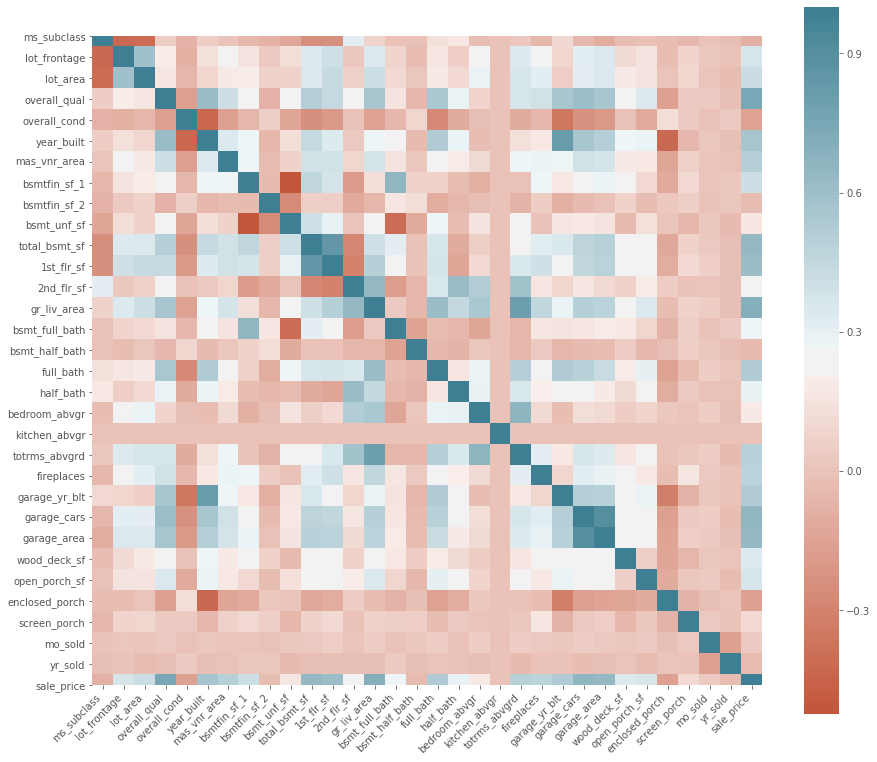

In [26]:
# check for collinearity among continuous features
# before selecting which ones to use together
plt.figure(figsize=(15,13))
ax = sns.heatmap(correlations,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment="right"
)
plt.show()

It looks like we have a decent amount of variables that are correlated (positively or negatively) with our dependent variable, `sale_price`. Let's set a cutoff for what the strength of the relationship between a feature and `sale_price` should be, and then move forward with the variables whose correlations with `y` are strongest. 

In [27]:
# get the absolute value of each correlation
abs_corr_y = corr_y.abs()
cutoff = .3

# use the strength of each relationship 
# to weed out continuous variables
good_cont_vars = list(abs_corr_y[abs_corr_y >= cutoff].index)
good_cont_vars.remove("sale_price")
print(good_cont_vars)

['lot_frontage', 'lot_area', 'overall_qual', 'year_built', 'mas_vnr_area', 'bsmtfin_sf_1', 'total_bsmt_sf', '1st_flr_sf', 'gr_liv_area', 'full_bath', 'totrms_abvgrd', 'fireplaces', 'garage_yr_blt', 'garage_cars', 'garage_area', 'wood_deck_sf', 'open_porch_sf']


Judging by our heatmap above, it looks like several of the variables that we've kept are collinear with one another. For each of these pairs, let's remove one so that we can avoid feeding duplicate information into our model. 

In [28]:
# update contents of our list of continuous variables
collinear_vars = [ "lot_frontage", "garage_yr_blt", "garage_cars" ]
cont_vars = [ col for col in good_cont_vars if col not in collinear_vars ]

print(f"final list of continuous variables: {cont_vars}")

final list of continuous variables: ['lot_area', 'overall_qual', 'year_built', 'mas_vnr_area', 'bsmtfin_sf_1', 'total_bsmt_sf', '1st_flr_sf', 'gr_liv_area', 'full_bath', 'totrms_abvgrd', 'fireplaces', 'garage_area', 'wood_deck_sf', 'open_porch_sf']


Now that we've narrowed down our list of continuous features, let's work on choosing between the other kinds of features we have. Since the following variables are not continuous, we weren't able to rely on correlation in order to test the relationships between them and our dependent variable. This mean we'll have to rely on other statistical methods. 

In order to figure out which methods we should or shouldn't use, let's check on the distribution of our dependent variable and see if it's normally distributed. This will inform our decision-making later on. 

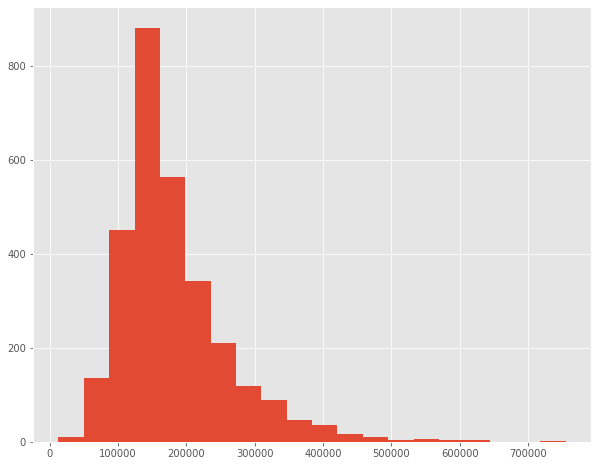

In [29]:
# see if dependent variable is normally distributed
y = data["sale_price"].copy()
y.hist(bins=20, figsize=(10,8))

Since our dependent variable is right-skewed, we'll need to rely on nonparametric statistical tests in order to choose between our remaining variables. Let's dive right in. 

First, let's test our categorical variables using the Kruskal-Wallis One-Way ANOVA by Ranks. This statistical test is employed with ordinal data in a hypothesis testing situation where there are two or more independent samples. For any of the following variables, if we get a result that is greater than a certain critical value (which can be found in statistics textbooks and online), and the p-value is statistically significant, we will be able to say there is evidence to conclude that a change in the given variable will result in a change in the `sale_price` of a given home. 

In [30]:
# get categorical variables for testing
categorical = [ col for col in data.columns if col.startswith("n_") ]
X_categorical = categorical

# run kruskal-wallis h test on each categorical variable
alpha = 0.1
for c in X_categorical:
    samples = {}
    # randomly sample from population if enough n;
    # set up variable for disposal if not
    for s in set(data[c].tolist()):
        samples[s] = data["sale_price"][data[c] == s].copy()
        if len(list(samples[s])) > 7:
            samples[s] = samples[s].sample(n=5, random_state=1)
        else:
            break
    # check if all values for c have enough n for test,
    # automatically disqualify the variable if not
    if len(list(samples.keys())) < len(set(data[c].tolist())):
        print(f"{c}: one or more sample n insufficient for kruskal-wallis h test", "\n")
        continue
    else:
        stat, p = scipy.stats.kruskal(*samples.values())
        print(f"{c}: h-stat: {stat}, p: {p}, k: {len(list(samples.keys()))}")
        if p < alpha:
            print("reject null hypothesis", "\n")
        else:
            print("unable to reject null hypothesis", "\n")

n_exter_qual: h-stat: 16.005714285714276, p: 0.0011309294064170573, k: 4
reject null hypothesis 

n_exter_cond: one or more sample n insufficient for kruskal-wallis h test 

n_heating_qc: one or more sample n insufficient for kruskal-wallis h test 

n_functional: one or more sample n insufficient for kruskal-wallis h test 



It looks like our `n_exter_qual` variable exceeds the critical value of 6 for a Kruskal-Wallis hypothesis test in which the number of distinct populations `k` is greater than 4 (using a p-value of .1). We've now established there is evidence of a relationship between this variable and `sale_price`, which we could not do for the others. So we will be moving on with `n_exter_qual` and dropping the other features we've tested here. 

In [31]:
# drop columns based on the above rationale
to_drop = [ "n_exter_cond", "n_heating_qc", "n_functional" ]
data.drop(columns=to_drop, inplace=True)

# normalize new features
new_features = [ "n_exter_qual", "years_until_remod" ]
data["n_exter_qual"] = normalize(data[new_features], axis=0)

Now, let's repeat our Kruskal-Wallis hypothesis test on each of our dummy variables. Each dummy variable exists in our data as a series of boolean columns. Each of these boolean columns represents a single value that our dummy variable can take, and these are mutually-exclusive. Because of this, we'll have to group the positive values of each variable to study the difference each of these values makes in the label, `sale_price`. 

In [32]:
# get lists of values for dummy variables
to_dummy = ["ms_zoning", "lot_shape", "land_contour", "utilities",
            "lot_config", "land_slope", "neighborhood", "bldg_type",
            "house_style", "roof_style", "exterior_1st", "exterior_2nd",
            "heating", "electrical", "street", "foundation",
            "bsmt_qual", "bsmt_cond", "bsmt_exposure", "kitchen_qual",
            "garage_type", "garage_finish", "garage_qual" ]

dummy_groups = {}

# show available dummy variables,
# along with their corresponding columns
for col in to_dummy:
    print(f"{col}:")
    values = made_into_dummies[col].unique().tolist()
    dummy_names = [ "d_" + name.replace(" ", "_").lower() for name in values ]
    print(dummy_names)
    dummy_groups[col] = dummy_names

ms_zoning:
['d_rl', 'd_rh', 'd_fv', 'd_rm', 'd_c_(all)', 'd_i_(all)', 'd_a_(agr)']
lot_shape:
['d_ir1', 'd_reg', 'd_ir2', 'd_ir3']
land_contour:
['d_lvl', 'd_hls', 'd_bnk', 'd_low']
utilities:
['d_allpub', 'd_nosewr', 'd_nosewa']
lot_config:
['d_corner', 'd_inside', 'd_culdsac', 'd_fr2', 'd_fr3']
land_slope:
['d_gtl', 'd_mod', 'd_sev']
neighborhood:
['d_names', 'd_gilbert', 'd_stonebr', 'd_nwames', 'd_somerst', 'd_brdale', 'd_npkvill', 'd_nridght', 'd_blmngtn', 'd_noridge', 'd_sawyerw', 'd_sawyer', 'd_greens', 'd_brkside', 'd_oldtown', 'd_idotrr', 'd_clearcr', 'd_swisu', 'd_edwards', 'd_collgcr', 'd_crawfor', 'd_blueste', 'd_mitchel', 'd_timber', 'd_meadowv', 'd_veenker', 'd_grnhill', 'd_landmrk']
bldg_type:
['d_1fam', 'd_twnhse', 'd_twnhs', 'd_duplex', 'd_2fmcon']
house_style:
['d_1story', 'd_2story', 'd_1.5fin', 'd_sfoyer', 'd_slvl', 'd_2.5unf', 'd_1.5unf', 'd_2.5fin']
roof_style:
['d_hip', 'd_gable', 'd_mansard', 'd_gambrel', 'd_shed', 'd_flat']
exterior_1st:
['d_brkface', 'd_vinyls

In [33]:
# run kruskal-wallis h test on each dummy,
# keep list of useful dummy variables
useful_dummies = []

for key, values_list in dummy_groups.items():
    samples = {}
    # get sample of observations having
    # positive values for each dummy
    for value in values_list:
        if isinstance(data[value], pd.Series):
            samples[value] = data["sale_price"][data[value] == 1].copy()
            if len(list(samples[value])) > 7:
                samples[value] = samples[value].sample(n=5, random_state=1)
            else:
                break
        elif isinstance(data[value], pd.DataFrame):
            index_ = data[value].iloc[:, 0].copy()
            samples[value] = data["sale_price"].loc[index_ == 1].copy()
            if len(list(samples[value])) > 7:
                samples[value] = samples[value].sample(n=5, random_state=1)
            else:
                break
        else:
            continue
    # check if all values for c have enough n for test,
    # automatically disqualify the variable if not
    if len(list(samples.keys())) < len(values_list):
        print(f"{key}: one or more sample n insufficient for kruskal-wallis h test", "\n")
        continue
    else:
        stat, p = scipy.stats.kruskal(*samples.values())
        print(f"{key}: h-stat: {stat}, p: {p}, k: {len(values_list)}")
        if p < alpha:
            useful_dummies.append(values_list)
            print("reject null hypothesis", "\n")
        else:
            print("unable to reject null hypothesis", "\n")

ms_zoning: one or more sample n insufficient for kruskal-wallis h test 

lot_shape: h-stat: 2.1314285714285717, p: 0.5455807628152345, k: 4
unable to reject null hypothesis 

land_contour: h-stat: 7.251428571428576, p: 0.06430133878002188, k: 4
reject null hypothesis 

utilities: one or more sample n insufficient for kruskal-wallis h test 

lot_config: h-stat: 2.232858791843016, p: 0.6930182298881448, k: 5
unable to reject null hypothesis 

land_slope: h-stat: 0.9066189624329171, p: 0.6355214212460584, k: 3
unable to reject null hypothesis 

neighborhood: one or more sample n insufficient for kruskal-wallis h test 

bldg_type: h-stat: 6.818622547133516, p: 0.14578931169301035, k: 5
unable to reject null hypothesis 

house_style: h-stat: 19.05942953649841, p: 0.008003195925205105, k: 8
reject null hypothesis 

roof_style: one or more sample n insufficient for kruskal-wallis h test 

exterior_1st: one or more sample n insufficient for kruskal-wallis h test 

exterior_2nd: one or more sam

It looks like of all the dummy variables we've created, nine have passed our Kruskal-Wallis hypothesis test, exceeding our critical values for each value of `k` as well as staying at a low enough p so that we know these results are unlikely to have happened by chance. 

However, it looks like one or more of the neighborhoods described by the dummies created from the `neighborhood` column didn't have enough positive examples to run the hypothesis test. Since the idea that real estate is "all about location" is a famous cliche, let's make a judgment call and add it into the list of variables we'll move forward with. 

In [34]:
# going to make a judgment call and include neighborhood dummies as well
nbhd_dummies = dummy_groups["neighborhood"]
useful_dummies.append(nbhd_dummies)

print(f"final list of dummy columns: {useful_dummies}")

final list of dummy columns: [['d_lvl', 'd_hls', 'd_bnk', 'd_low'], ['d_1story', 'd_2story', 'd_1.5fin', 'd_sfoyer', 'd_slvl', 'd_2.5unf', 'd_1.5unf', 'd_2.5fin'], ['d_sbrkr', 'd_fusea', 'd_fusef', 'd_fusep', 'd_mix'], ['d_ta', 'd_gd', 'd_ex', 'd_no_info_1', 'd_fa', 'd_po'], ['d_gd', 'd_no', 'd_mn', 'd_av', 'd_no_info_3'], ['d_ta', 'd_gd', 'd_ex', 'd_fa', 'd_po'], ['d_attchd', 'd_builtin', 'd_basment', 'd_detchd', 'd_no_info_6', 'd_carport', 'd_2types'], ['d_fin', 'd_unf', 'd_rfn', 'd_no_info_7'], ['d_ta', 'd_no_info_8', 'd_fa', 'd_gd', 'd_ex', 'd_po'], ['d_names', 'd_gilbert', 'd_stonebr', 'd_nwames', 'd_somerst', 'd_brdale', 'd_npkvill', 'd_nridght', 'd_blmngtn', 'd_noridge', 'd_sawyerw', 'd_sawyer', 'd_greens', 'd_brkside', 'd_oldtown', 'd_idotrr', 'd_clearcr', 'd_swisu', 'd_edwards', 'd_collgcr', 'd_crawfor', 'd_blueste', 'd_mitchel', 'd_timber', 'd_meadowv', 'd_veenker', 'd_grnhill', 'd_landmrk']]


In [35]:
# get combined list of all features
narrowed_fset = cont_vars + useful_dummies + [ "n_exter_qual" ]

print(f"current number of features: {len(narrowed_fset)}")

current number of features: 25


But first of all, let's deal with the problem of our dummy variables. Since we need to pass all of our dummy variables into our list together, we need to keep them in lists. However, we can't pass in a list of columns into our model; they need to be passed in as individual columns, like all the others. Let's solve this problem by creating a function, `flatten_fset`, that will take each feature-set we pass into it, and if it contains a list, it will take all the values inside and add them to the main list so that they're like any other variable. 

In [36]:
def flatten_fset(list_):
    for item in list_:
        if isinstance(item, list) and not isinstance(item, str):
            yield from flatten_fset(item)
        else:
            yield item

In [37]:
# reduce original dataframe using columns
# we've decided on keeping
feature_set = list(flatten_fset(narrowed_fset))

# make sure we don't get rid of our dependent var
feature_set.append("sale_price")
data = data[feature_set].copy()

Now let's create a holdout dataset. This will enable us to test our model on data that remains completely unseen to it, allowing us to get a measure of how well it will generalize. 

In [38]:
# data pre-processing
X_train = data.sample(frac=0.8, axis=0, random_state=1)
X_test = data.drop(X_train.index)

# Separate target from features
y_train = X_train.pop("sale_price")
y_test = X_test.pop("sale_price")

In [39]:
# have a look at our training data
X_train.head()

,lot_area,overall_qual,year_built,mas_vnr_area,bsmtfin_sf_1,total_bsmt_sf,1st_flr_sf,gr_liv_area,full_bath,totrms_abvgrd,fireplaces,garage_area,wood_deck_sf,open_porch_sf,d_lvl,d_hls,d_bnk,d_low,d_1story,d_2story,d_1.5fin,d_sfoyer,d_slvl,d_2.5unf,d_1.5unf,d_2.5fin,d_sbrkr,d_fusea,d_fusef,d_fusep,d_mix,d_ta,d_ta,d_ta,d_ta,d_gd,d_gd,d_gd,d_gd,d_gd,d_ex,d_ex,d_ex,d_ex,d_no_info_1,d_fa,d_fa,d_fa,d_fa,d_po,d_po,d_po,d_po,d_gd,d_gd,d_gd,d_gd,d_gd,d_no,d_mn,d_av,d_no_info_3,d_ta,d_ta,d_ta,d_ta,d_gd,d_gd,d_gd,d_gd,d_gd,d_ex,d_ex,d_ex,d_ex,d_fa,d_fa,d_fa,d_fa,d_po,d_po,d_po,d_po,d_attchd,d_builtin,d_basment,d_detchd,d_no_info_6,d_carport,d_2types,d_fin,d_unf,d_rfn,d_no_info_7,d_ta,d_ta,d_ta,d_ta,d_no_info_8,d_fa,d_fa,d_fa,d_fa,d_gd,d_gd,d_gd,d_gd,d_gd,d_ex,d_ex,d_ex,d_ex,d_po,d_po,d_po,d_po,d_names,d_gilbert,d_stonebr,d_nwames,d_somerst,d_brdale,d_npkvill,d_nridght,d_blmngtn,d_noridge,d_sawyerw,d_sawyer,d_greens,d_brkside,d_oldtown,d_idotrr,d_clearcr,d_swisu,d_edwards,d_collgcr,d_crawfor,d_blueste,d_mitchel,d_timber,d_meadowv,d_veenker,d_grnhill,d_landmrk,n_exter_qual
2127,0.016936,0.017912,0.018711,0.000000,0.020110,0.013701,0.013973,0.021269,0.022754,0.019809,0.000000,0.024801,0.000000,0.042785,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.016077
192,0.014136,0.020897,0.018009,0.000000,0.014710,0.018423,0.017910,0.024627,0.011377,0.022639,0.021272,0.011422,0.000000,0.000000,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.016077
2573,0.014807,0.014926,0.018355,0.014031,0.023213,0.019022,0.017663,0.013623,0.011377,0.016980,0.021272,0.028862,0.011436,0.000000,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.016077
45,0.011556,0.020897,0.018805,0.014031,0.022748,0.022580,0.020967,0.016172,0.022754,0.016980,0.021272,0.017549,0.025531,0.009244,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.021436
2477,0.015063,0.017912,0.018711,0.000000,0.000000,0.015646,0.014529,0.021876,0.022754,0.019809,0.000000,0.024946,0.019946,0.043578,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.016077


Looking at our data, we can see that we now have a fairly large (but not overwhelming) list of features to draw upon as we move on to the next stage of this notebook. 

In [40]:
# organize final subsets of features chosen for training
continuous_fs = [ col for col in X_train if not col.startswith("d") ]
dummy_fs = useful_dummies
all_features = continuous_fs + dummy_fs

feature_set = list(flatten_fset(all_features))

### Training loop
Now that we've finished with the process of housekeeping for our features, we can focus on the model we will be using for prediction. Below, we'll train a random forest regressor on our data and see if the features we've retained out of the 80 original ones do a good job of helping predict the sale price of each house. 

We'll help along the training process using grid search in order to choose the hyperparameters that minimize our error score. 

In [41]:
rfr = RandomForestRegressor(random_state=1)
param_grid = {
    "n_estimators": [ 700, 900, 1100 ],
    "max_features": [ 25, 50, 75, 100 ]
}
model = GridSearchCV(estimator=rfr, param_grid=param_grid,
                     cv=5, scoring="neg_mean_absolute_error")
model.fit(X_train, y_train)

print(f"best parameters: {model.best_params_}")
print(f"best CV score: {-model.best_score_}")

KeyboardInterrupt: 

It looks like the 25 features we've chosen do a pretty good job of valuing each house by themselves, given that house prices can vary by hundreds of thousands of dollars. Though the handful of dummy variables we've chosen amount to over 100 columns, it looks like they've done a pretty good job of determining what the price of a given house should be based on just a few of its attributes. Let's take a look at what the most important of these attributes were. 

In [0]:
forest = RandomForestRegressor(n_estimators=700,
                               max_features=25, random_state=1)
forest.fit(X_train, y_train)

f_importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(f_importances)[::-1]
cols = list(X_train.columns)
impt_cols = []

print("feature ranking: ")

for f in range(X_train.shape[1]):
    print(f"{f + 1}. {cols[indices[f]]} ({f_importances[indices[f]]})")
    impt_cols.append(cols[indices[f]])

In [0]:
plt.figure(figsize=(10,8))
plt.title("importance of top 25 features")
plt.bar(range(X_train.shape[1]), f_importances[indices],
        align="center")
plt.xticks(range(X_train.shape[1]), impt_cols, rotation="vertical")
plt.xlim(-1, 25)
plt.show()

It looks like the results of our training process are pretty intuitive. In the eyes of our model, the important features have to do with the __relative age and size__ of the house in question, things which wouldn't surprise any realtor. The __size of the general living area__ appears to be the most important spatial consideration, followed by the size of the __rez-de-chaussée__ and __basement__, and then the __size of the lot__ the house is in. 

The quality of the house's amenities also seems to have a marked effect on the price, specifically the __quality of the basement, kitchen, and garage__. The total __number of rooms above ground__ also appears to have a decisive impact on sale price. 

Of the neighborhoods in Ames, the ones that appear to add the most to a given house's value appear to be __Northridge__, __Edwards__ and __Crawford__. 